In [1]:
cd ../../

/mnt/sda/otani/Experiments/hidden-challenges-MR


In [2]:
from src import settings
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.toolbox.eval import evaluate, accumulate_metrics
from src.toolbox.utils import _nms
from src.toolbox.visualization import plot_performance_per_duration
from src.toolbox.data_converters import CharadesSTA2Instances
import seaborn as sns
import pickle as pkl
import json
import neptune
sns.set_style("white")

In [5]:
# load ground truth test set
test_data = CharadesSTA2Instances(pd.read_csv('data/processed/charades/charades_test.csv'))

In [6]:
project = neptune.init("mayu-ot/moment-retrieval")
exp_id = "MOM-6"
if not os.path.exists(f"tmp/{exp_id}/{exp_id}199.json"):
    exps = project.get_experiments(id=exp_id)
    print("downloading results ...")
    exps[0].download_artifact(f"{exp_id}199.json", f"tmp/{exp_id}")
    print("done!")
    
exp_id = "MOM-7"
if not os.path.exists(f"tmp/{exp_id}/{exp_id}199.shuffle.json"):
    exps = project.get_experiments(id=exp_id)
    print("downloading results ...")
    exps[0].download_artifact(f"{exp_id}199.shuffle.json", f"tmp/{exp_id}")
    print("done!")

downloading results ...
done!
downloading results ...
done!


In [7]:
def get_duration(video_id):
    for x in test_data:
        if x[0][0] == video_id:
            return x[1][-1]

def postproc_prediction(predictions):
    preds = []
    for p in tqdm(predictions, desc="postproc"):
        query = (p[0], p[2]+".")
        video_duration = get_duration(query[0])
        seg = [s + [video_duration] for s in p[3][:5]]
        preds.append((query, seg, p[5][:5]))
    return preds

def eval_preds(pred_file, data):
    print(f"loading prediction file {pred_file}")
    predictions = json.load(open(pred_file))
    preds = postproc_prediction(predictions)
    results = evaluate(data, preds)
    summary = accumulate_metrics(results)
    return results, summary

results, summary = eval_preds("tmp/MOM-6/MOM-6199.json", test_data)
randomized_results, randomized_summary = eval_preds("tmp/MOM-7/MOM-7199.shuffle.json", test_data)

postproc:  31%|███       | 1135/3712 [00:00<00:00, 11341.74it/s]

loading prediction file tmp/MOM-6/MOM-6199.json


evaluating:  14%|█▍        | 528/3720 [00:00<00:00, 5272.12it/s]

8 missing instances
missing item: ('U2AO1', 'closes the doors.the person takes the food.')


postproc:   0%|          | 0/3712 [00:00<?, ?it/s]

missing item: ('SVIXG', 'person opening a box.')
missing item: ('SVIXG', 'person eating from a box of food.')
missing item: ('SVIXG', 'person eating something out of it.')
missing item: ('SVIXG', 'person eats a few pieces from inside.')
missing item: ('7JHW2', 'the person puts the laptop down onto a table.')
missing item: ('7JHW2', 'a person runs into the garage.')
missing item: ('7JHW2', 'person holding a laptop.')
missing item: ('7JHW2', 'person sets a laptop computer on a counter.')
R@1 IoU>0.3 0.65
R@1 IoU>0.5 0.52
R@1 IoU>0.7 0.31
R@5 IoU>0.3 0.82
R@5 IoU>0.5 0.73
R@5 IoU>0.7 0.56
R@10 IoU>0.3 0.82
R@10 IoU>0.5 0.73
R@10 IoU>0.7 0.56
loading prediction file tmp/MOM-7/MOM-7199.shuffle.json


evaluating:  14%|█▍        | 526/3720 [00:00<00:00, 5247.81it/s]

8 missing instances
missing item: ('U2AO1', 'closes the doors.the person takes the food.')


evaluating: 100%|██████████| 3720/3720 [00:00<00:00, 5600.19it/s]


missing item: ('SVIXG', 'person opening a box.')
missing item: ('SVIXG', 'person eating from a box of food.')
missing item: ('SVIXG', 'person eating something out of it.')
missing item: ('SVIXG', 'person eats a few pieces from inside.')
missing item: ('7JHW2', 'the person puts the laptop down onto a table.')
missing item: ('7JHW2', 'a person runs into the garage.')
missing item: ('7JHW2', 'person holding a laptop.')
missing item: ('7JHW2', 'person sets a laptop computer on a counter.')
R@1 IoU>0.3 0.39
R@1 IoU>0.5 0.25
R@1 IoU>0.7 0.12
R@5 IoU>0.3 0.65
R@5 IoU>0.5 0.49
R@5 IoU>0.7 0.31
R@10 IoU>0.3 0.65
R@10 IoU>0.5 0.49
R@10 IoU>0.7 0.31


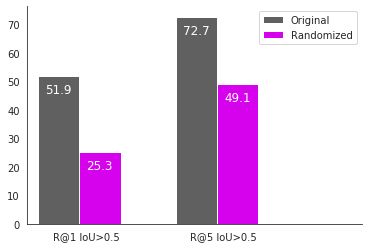

In [10]:
# The performances of the SCDM model when the original and randomized videos are fed to the model
def display_score(bar, color="w"):
    plt.text(
        bar.get_x()+bar.get_width()*.5,
        bar.get_height()-6,
        f"{bar.get_height():.1f}",
        horizontalalignment="center",
        fontsize=12,
        color=color
    )
    
def plot_performance_comparison(sum_a, sum_b, labels):
    plt.figure(figsize=(6, 4))
    c = ["#606060", "#d602ee"]
    keys = [f"R@{k} IoU>0.5" for k in [1, 5]]
    x = np.arange(2)+0.2
    for score_summary, l in zip([sum_a, sum_b], labels):
        vals = [score_summary[k] * 100 for k in keys]
        bars = plt.bar(x, vals, width=0.3, color=c.pop(0), label=l)
        for b in bars:
            display_score(b, color="w")
        x += 0.3

    plt.xticks(ticks=np.arange(3)+0.4, labels=keys, ha="center")
    plt.legend()
    sns.despine(left=False)

plot_performance_comparison(summary, randomized_summary, labels = ["Original", "Randomized"])

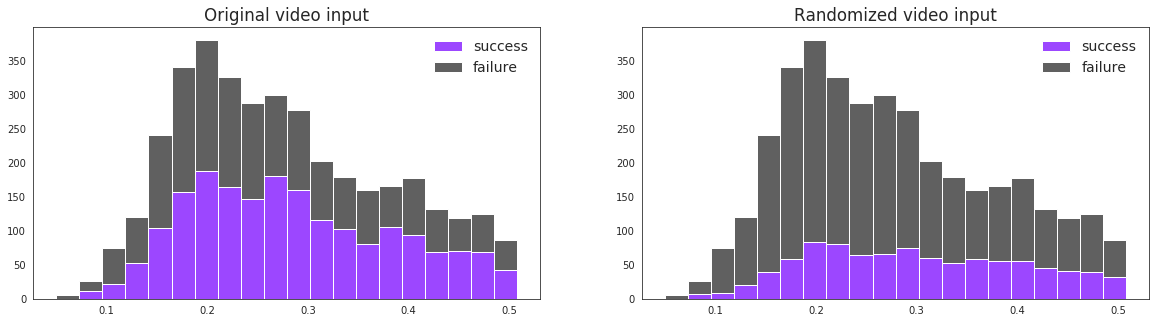

In [11]:
# Check relation between success rates and iput video durations
def plot_comparison_per_duration(results, titles, data):
    f, axes = plt.subplots(1, len(results), figsize=(20, 5))
    plt.rcParams.update({'font.size': 14})
    
    for ax, res, t in zip(axes, results, titles):
        _ = plot_performance_per_duration(res, data, ax=ax)
        ax.set_title(t)


plot_comparison_per_duration(
    (results, randomized_results), 
    ["Original video input", "Randomized video input"],
    test_data)